# SpikeInterface DEMO v0.101 - Neuralnet -  Saclay - November 2024

For this demo we will use a small file provided by Eduarda Centeno, Arthur Leblois and Aude Retailleau from IMN lab in Bordeaux.

It is a recording from a zebra finch for testing the probe ASSY-236-H5 from cambridge neurotech.

![](img/zebra_finch.jpeg)

The recording system is the openephys usb3 board.


This file is only for testing or teaching purposes.

# Table of contents

* [0. Preparation](#preparation)
* [1. Reading recording and sorting](#loading)
* [2. Preprocessing](#preprocessing)
* [3. Saving and loading SpikeInterface objects](#save-load)
* [4. Spike sorting](#spike-sorting)
* [5. Postprocessing and SortingAnalyzer](#postprocessing)
* [6. Validation and curation](#curation)
* [7. Viewers](#viewers)
* [8. Spike sorting comparison](#comparison)
* [9. Exporters](#exporters)

# 0. Preparation <a class="anchor" id="preparation"></a>

### Download the ephys data

Tthe data `cambridgeneurotech_openephys_recording.zip` can be downloaded from here:

https://drive.google.com/drive/folders/17RlgsMLheW82IMLMgmTFifVACebDZ8X5?usp=sharing



In [1]:
# spikeinterface has manu submodules: here this is the lazy way to import all of then!
import spikeinterface.full as si

In [2]:
print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.101.1


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.simplefilter("ignore")

# %matplotlib widget
%matplotlib inline

# 1. Reading recording and sorting <a class="anchor" id="loading"></a>

In [4]:
base_folder = Path('/home/samuel/DataSpikeSorting/gdr2024_tutorials/')
oe_folder = base_folder / "openephys_recording" / "2023-08-23_15-56-05"

In [5]:
full_raw_rec = si.read_openephys(oe_folder)

The `read_openephys()` function returns a `Recording` (or `RecordingExtractor`) object. We can print it to visualize some of its properties:

In [6]:
print(full_raw_rec)

OpenEphysBinaryRecordingExtractor: 72 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                                   300.00s (5.00 minutes) - int16 dtype - 1.21 GiB


In [7]:
full_raw_rec

OpenEphysBinaryRecordingExtractor: 72 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                                   300.00s (5.00 minutes) - int16 dtype - 1.21 GiB

`spikeinterface.extractors` integrate many readers:

  * `read_nwb()`
  * `read_blackrock()`
  * `read_spikeglx()`
  * ...


For a full list see the documentation [here](https://spikeinterface.readthedocs.io/en/latest/modules/extractors.html).

A `Recording` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted).

SpikeInterface supports multi-segment recordings. A segment is a contiguous piece of data, and sometimes recordings can be made of multiple acquisitions, for examples a baseline, a stimulation phase, and a post recording. In such cases, the recording object will be made of multiple segments and be treated as such over the pipeline.

The `get_traces()` function returns a TxN numpy array where N is the number of channel ids passed in (all channel ids are passed in by default) and T is the number of frames (determined by start_frame and end_frame).

In [8]:
fs = full_raw_rec.get_sampling_frequency()
trace_snippet = full_raw_rec.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

In [9]:
print('Traces shape:', trace_snippet.shape)

Traces shape: (60000, 72)


Before moving on with the analysis, we have to load the probe information. For this we will use the [ProbeInterface](https://probeinterface.readthedocs.io/en/main/index.html) package. 

ProbeInterface allows to easily create, manipulate, and visualize neural probes. Moreover, it comes with a wide range of IO functions to import and export existing formats. Finally, we have created a public library of commercial probes (https://github.com/SpikeInterface/probeinterface_library) that can be retrieved with a single line of code.

Let's import `probeinterface`, download the probe and plot it!

In [10]:
import probeinterface as pi
from probeinterface.plotting import plot_probe

In [11]:
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-236-H5'

probe = pi.get_probe(manufacturer, probe_name)
print(probe)

ASSY-236-H5 - cambridgeneurotech - 64ch - 1shanks


In most experiments, the neural probe has a connector, that is interfaced to an headstage, which in turn connects to the acquisition system. This *pathway* usually results in a channel remapping, which means that the order of the contacts on the probe is different than the order of the recorded traces.

`probeinterface` provides a growing collection of common pathways that can be loaded directly to wire a device and apply the correct channel mapping:

In [12]:
pi.get_available_pathways()

['H32>RHD2132',
 'ASSY-156>RHD2164',
 'ASSY-116>RHD2132',
 'ASSY-77>Adpt.A64-Om32_2x-sm-NN>RHD2164',
 'ASSY-77>Adpt.A64-Om32_2x-sm-NN>two_RHD2132',
 'cambridgeneurotech_mini-amp-64']

In [13]:
probe.wiring_to_device('cambridgeneurotech_mini-amp-64')

(-50.0, 300.0)

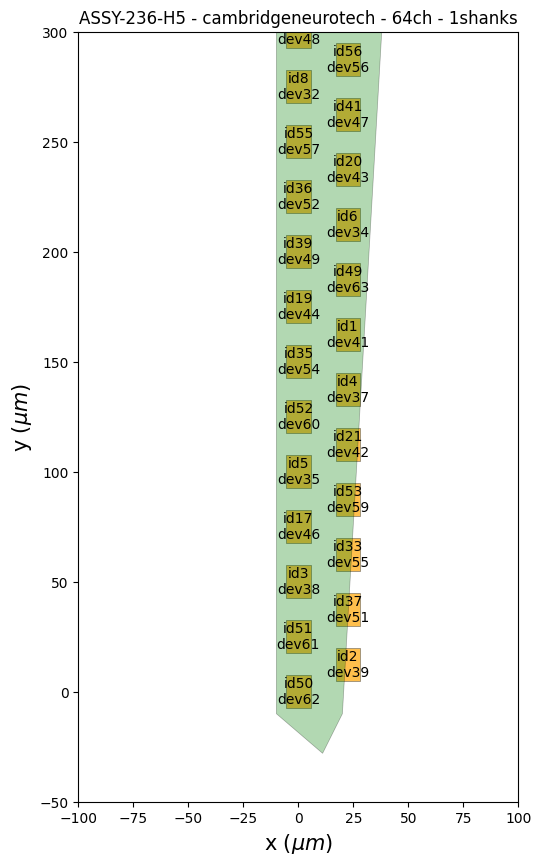

In [14]:
fig, ax = plt.subplots(figsize=(14, 10))
w = plot_probe(probe, ax=ax, with_contact_id=True, with_device_index=True)
ax.set_xlim(-100, 100)
ax.set_ylim(-50, 300)

The probe now has contact ids `id#` and device ids `dev#`! The `device_channel_index` is the index of the trace corresponding to the contact. For example, the bottom left contact is the 62-th signal in the recording.

When loading the probe, the device indices (and all the other contact properties) are automatically sorted.
And **very importantly** the recording is reduced to 64 channels, because the other 8 channels are auxiliary channels.

In [15]:
raw_rec = full_raw_rec.set_probe(probe)
raw_rec

ChannelSliceRecording: 64 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                       300.00s (5.00 minutes) - int16 dtype - 1.07 GiB

We can now visualize the `channel_id` (channel name) from Open Ephys.

(-50.0, 300.0)

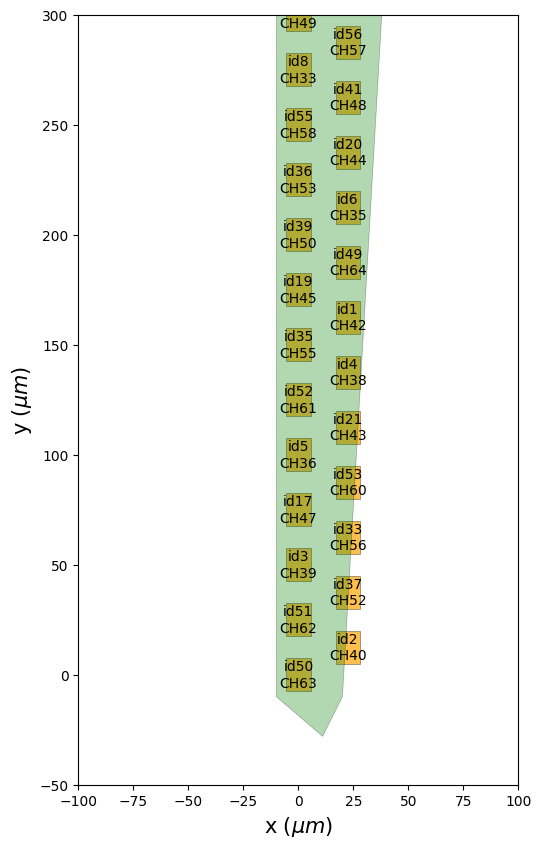

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))
w = si.plot_probe_map(raw_rec, with_channel_ids=True, with_contact_id=True, ax=ax)
ax.set_xlim(-100, 100)
ax.set_ylim(-50, 300)

The `widgets` module includes several convenient plotting functions that can be used to explore the data:

In [17]:
%matplotlib widget
w = si.plot_traces(raw_rec, backend="ipywidgets", mode='map')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

### Properties 

`Recording` objects can have *properties*. A property is a piece of information attached to a channel, e.g. group or location.

Similarly, for `Sorting` objects (that we'll cover later), anything related to a unit can be stored as a property. 

We can check which properties are in the extractor as follows:

In [18]:
print("Properties:\n", list(raw_rec.get_property_keys()))

Properties:
 ['gain_to_uV', 'offset_to_uV', 'channel_names', 'contact_vector', 'location', 'group']


We can also specify a property on a subset of channels. In this case, the non-specified channels will be filled empty values:

In [19]:
raw_rec.set_property(key='quality', values=["good"]*(raw_rec.get_num_channels() - 3),
                     ids=raw_rec.get_channel_ids()[:-3])
raw_rec

ChannelSliceRecording: 64 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                       300.00s (5.00 minutes) - int16 dtype - 1.07 GiB

In [39]:
raw_rec.get_property("quality")[-10:]

array(['good', 'good', 'good', 'good', 'good', 'good', 'good', '', '', ''],
      dtype='<U4')

### Annotations

*Annotations* can be attached to any object and they can carry any information related to the recording or sorting objects.

Let's add an annotation about this tutorial:

In [20]:
raw_rec.annotate(description="Dataset for SI tutorial")
raw_rec

ChannelSliceRecording: 64 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                       300.00s (5.00 minutes) - int16 dtype - 1.07 GiB

In [41]:
print(raw_rec.get_annotation_keys())

['is_filtered', 'probe_0_planar_contour', 'description']


# 2. Preprocessing <a class="anchor" id="preprocessing"></a>


Now that the probe information is loaded we can do some preprocessing using `preprocessing` module.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. (more info [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

For this notebook, let's filter the recordings and apply common median reference (CMR). 
**IMPORTANT:** All preprocessing functions return new `Recording` objects that apply the underlying preprocessing operation when requested. This allows users to access the preprocessed data in the same way as the raw data.

Below, we bandpass filter the recording and apply common median reference to the original recording:

In [21]:
recording_f = si.bandpass_filter(raw_rec, freq_min=300, freq_max=9000)
print(recording_f)

BandpassFilterRecording: 64 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                         300.00s (5.00 minutes) - int16 dtype - 1.07 GiB


Let's now apply Common Median Reference (CMR):

In [22]:
recording_cmr = si.common_reference(recording_f, reference='global', operator='median')
print(recording_cmr)

CommonReferenceRecording: 64 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                          300.00s (5.00 minutes) - int16 dtype - 1.07 GiB


We can plot the traces after applying CMR:

In [23]:
recording_layers = dict(
    filt=recording_f,
    common=recording_cmr
)

w = si.plot_traces(recording_layers, mode='map', time_range=[10, 10.1], backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [ ]:
%gui qt
w = si.plot_traces(recording_layers, mode='line', time_range=[10, 10.1], backend="ephyviewer")

The previous plot clearly shows some strange channels on the border.

We can detect then and remove then from the recording using the `detect_bad_channels` function.

In [24]:
bad_channel_ids, bad_channel_labels = si.detect_bad_channels(recording_f, method='coherence+psd')
print(bad_channel_ids)
print(bad_channel_labels)

['CH1' 'CH2' 'CH3' 'CH4' 'CH5' 'CH6' 'CH7' 'CH8' 'CH40' 'CH57' 'CH58'
 'CH59' 'CH60' 'CH61' 'CH64']
['dead' 'dead' 'dead' 'dead' 'dead' 'dead' 'dead' 'dead' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'noise'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'dead' 'dead' 'dead' 'dead'
 'dead' 'good' 'good' 'dead']


In [25]:
recording_f_good = recording_f.remove_channels(bad_channel_ids)
print(recording_f_good)

ChannelSliceRecording: 49 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                       300.00s (5.00 minutes) - int16 dtype - 841.14 MiB


In [26]:
recording_cmr_good = si.common_reference(recording_f_good, reference='global', operator='median')
print(recording_cmr_good)

CommonReferenceRecording: 49 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                          300.00s (5.00 minutes) - int16 dtype - 841.14 MiB


In [27]:
%matplotlib widget
w = si.plot_traces(recording_cmr_good, mode='map',time_range=[10, 10.1], backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

## Take only 5 min. for demo

Since we are going to spike sort the data, let's first cut out a 5-minute recording, to speed up computations.

We can easily do so with the `frame_slice()` function:

In [30]:
fs = recording_cmr_good.get_sampling_frequency()
recording_shorten = recording_cmr_good.frame_slice(start_frame=0*fs, end_frame=300*fs)
recording_shorten

FrameSliceRecording: 49 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                     300.00s (5.00 minutes) - int16 dtype - 841.14 MiB

# 3. Saving and loading SpikeInterface objects <a class="anchor" id="save-load"></a>

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to **save** it to a file and perform those operations (eg. filters, CMR, etc.) at once. 


In [31]:
si.set_global_job_kwargs(n_jobs=-1, chunk_duration="1s", progress_bar=True)

In [32]:
if (base_folder / "preprocessed").is_dir():
    recording_saved = si.load_extractor(base_folder / "preprocessed")
else:
    recording_saved = recording_shorten.save(folder=base_folder / "preprocessed")

After saving the SI object, we can easily load it back in a new session:

In [33]:
recording_saved = si.load_extractor(base_folder / "preprocessed")

In [35]:
recording_saved

BinaryFolderRecording: 49 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                       300.00s (5.00 minutes) - int16 dtype - 841.14 MiB

**IMPORTANT**: the same saving mechanisms are available also for all SortingExtractor

# 4. Spike sorting <a class="anchor" id="spike-sorting"></a>

We can now run spike sorting on the above recording. We will use different spike sorters for this demonstration, to show how easy SpikeInterface makes it easy to interchengably run different sorters :)

Let's first check the available and installed sorters in `SpikeInterface`.
We will sort the bandpass cached filtered recording the `recording_saved` object.

In [36]:
si.available_sorters()

['combinato',
 'hdsort',
 'herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'kilosort2_5',
 'kilosort3',
 'kilosort4',
 'klusta',
 'mountainsort4',
 'mountainsort5',
 'pykilosort',
 'simple',
 'spykingcircus',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2',
 'waveclus',
 'waveclus_snippets',
 'yass']

In [37]:
si.installed_sorters()

['kilosort4', 'simple', 'spykingcircus2', 'tridesclous2']

The `spikeinterface.sortingcomponents` module includes functions that can be used to create custom spike sorting pipelines built-in in `SpikeInterface`. It is still experimental and under heavy development, but there are already 3  SI-based sorters available:

* `tridesclous2` (developed by Samuel Garcia)
* `spykingcircus2` (developed by Pierre Yger)
* `simple` which is only for demo and teaching

They can be run with the same `run_sorter` function, but they don't require any additional installation!

In [38]:
si.run_sorter?

Signature:
si.run_sorter(
    sorter_name: 'str',
    recording: 'BaseRecording',
    folder: 'Optional[str]' = None,
    remove_existing_folder: 'bool' = False,
    delete_output_folder: 'bool' = False,
    verbose: 'bool' = False,
    raise_error: 'bool' = True,
    docker_image: 'Optional[Union[bool, str]]' = False,
    singularity_image: 'Optional[Union[bool, str]]' = False,
    delete_container_files: 'bool' = True,
    with_output: 'bool' = True,
    output_folder: 'None' = None,
    **sorter_params,
)
Docstring:
Generic function to run a sorter via function approach.


Parameters
----------
sorter_name : str
    The sorter name
recording : RecordingExtractor
    The recording extractor to be spike sorted
folder : str or Path
    Path to output folder
remove_existing_folder : bool
    If True and folder exists then delete.
delete_output_folder : bool, default: False
    If True, output folder is deleted
verbose : bool, default: False
    If True, output is verbose
raise_error : b

We can retrieve the parameters associated to any sorter with the `get_default_params()` function from the `sorters` module:

In [39]:
si.get_default_sorter_params('kilosort2_5')

{'detect_threshold': 6,
 'projection_threshold': [10, 4],
 'preclust_threshold': 8,
 'whiteningRange': 32.0,
 'momentum': [20.0, 400.0],
 'car': True,
 'minFR': 0.1,
 'minfr_goodchannels': 0.1,
 'nblocks': 5,
 'sig': 20,
 'freq_min': 150,
 'sigmaMask': 30,
 'lam': 10.0,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'AUCsplit': 0.9,
 'do_correction': True,
 'wave_length': 61,
 'keep_good_only': False,
 'skip_kilosort_preprocessing': False,
 'scaleproc': None,
 'save_rez_to_mat': False,
 'delete_tmp_files': ('matlab_files',),
 'delete_recording_dat': False,
 'n_jobs': -1,
 'chunk_duration': '1s',
 'progress_bar': True,
 'mp_context': None,
 'max_threads_per_process': 1}

To modify a parameter, we can easily pass it to the `run` function as an extra argument!

### Run sorter locally

In [59]:
#si.Kilosort2_5Sorter.set_kilosort2_5_path('/home/samuel.garcia/Documents/SpikeInterface/code_sorters/Kilosort2.5/')
si.installed_sorters()

['kilosort4', 'simple', 'spykingcircus2', 'tridesclous2']

In [40]:
sorter_params = {'do_correction': False}

```python
sorting_KS25 = si.run_sorter('kilosort2_5', recording_saved,
                             output_folder=base_folder / 'sorter_KS25',
                             verbose=True, **sorter_params)
```

We can check the output object:

In [41]:
sorting_KS25 = si.read_sorter_folder(base_folder / 'sorter_KS25')
sorting_KS25

KiloSortSortingExtractor: 159 units - 1 segments - 30.0kHz

SpikeInterface ensures full provenance of the spike sorting pipeline. Upon running a spike sorter, a `spikeinterface_params.json` file is saved in the `output_folder`. This contains a `.json` version of the recording and all the input parameters. 

In [42]:
!ls {base_folder}/sorter_KS25

sorter_output		 spikeinterface_params.json
spikeinterface_log.json  spikeinterface_recording.json


In [63]:
!cat {base_folder}/sorter_KS25/spikeinterface_params.json

{
    "sorter_name": "kilosort2_5",
    "sorter_params": {
        "detect_threshold": 6,
        "projection_threshold": [
            10,
            4
        ],
        "preclust_threshold": 8,
        "momentum": [
            20.0,
            400.0
        ],
        "car": true,
        "minFR": 0.1,
        "minfr_goodchannels": 0.1,
        "nblocks": 5,
        "sig": 20,
        "freq_min": 150,
        "sigmaMask": 30,
        "lam": 10.0,
        "nPCs": 3,
        "ntbuff": 64,
        "nfilt_factor": 4,
        "NT": 65600,
        "AUCsplit": 0.9,
        "do_correction": false,
        "wave_length": 61,
        "keep_good_only": false,
        "skip_kilosort_preprocessing": false,
        "scaleproc": null,
        "save_rez_to_mat": false,
        "delete_tmp_files": [
            "matlab_files"
        ],
        "delete_recording_dat": false,
        "n_jobs": -1,
        "chunk_duration": "1s",
        "progress_bar": true,
        "mp_context": null,
        "ma

The spike sorting returns a `Sorting` object. Let's see some of its functions:

In [43]:
print(f'Spike train of a unit: {sorting_KS25.get_unit_spike_train(unit_id=1)}')
print(f'Spike train of a unit (in s): {sorting_KS25.get_unit_spike_train(unit_id=1, return_times=True)}')

Spike train of a unit: [   2277    2722    2984 ... 8967870 8992325 8993115]
Spike train of a unit (in s): [353.0359     353.05073333 353.05946667 ... 651.889      652.70416667
 652.7305    ]


We can use `spikewidgets` functions for some quick visualizations:

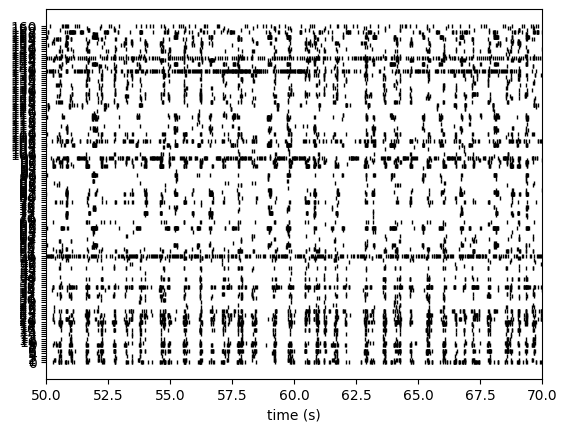

In [44]:
%matplotlib inline
w_rs = si.plot_rasters(sorting_KS25, time_range=(50., 70.))

We can also save a spike sorting output for future use:

In [46]:
sorting_saved_KS25 = sorting_KS25.save(folder=base_folder / "sorting_KS25")


### Run sorter in container

Some sorters are hard to install! To alleviate this headache, SI provides a built-in mechanism to run a spike sorting job in a docker container.

We are maintaining a set of sorter-specific docker files in the [spikeinterface-dockerfiles repo](<https://github.com/SpikeInterface/spikeinterface-dockerfiles>)
and most of the docker images are available on Docker Hub from the [SpikeInterface organization](<https://hub.docker.com/orgs/spikeinterface/repositories>).

Running spike sorting in a docker container just requires to:

1. have docker/singularity installed
2. have docker/singularity python SDK installed (`pip install docker/spython`)

When docker/singularity is installed, you can simply run the sorter in a container image:



```python
# run spike sorting on entire recording
sorting_KS2 = si.run_sorter('kilosort2', recording_saved, 
                            output_folder=base_folder / 'sorter_KS2',
                            verbose=True,
                            docker_image=True, 
                            **job_kwargs)
```

In [47]:
sorting_KS2 = si.read_sorter_folder(base_folder / 'sorter_KS2')
sorting_KS2

KiloSortSortingExtractor: 154 units - 1 segments - 30.0kHz

```python
sorting_KS4 = si.run_sorter('kilosort4', recording_saved, 
                            output_folder=base_folder / 'sorter_KS4',
                            verbose=True,
                            # sorter params
                            do_correction=False,
                )
```


In [48]:
sorting_KS4 = si.read_sorter_folder(base_folder / 'sorter_KS4')
sorting_KS4


KiloSortSortingExtractor: 110 units - 1 segments - 30.0kHz

# 5. Postprocessing and SortingAnalyzer <a class="anchor" id="postprocessing"></a>

The core of postprocessing spike sorting results need to paired recording-sorting objects.

In the `spikeinterface` API, `SortingAnalyzer` class in the `core` module is the base for any postprocessing.

The `SortingAnalyzer` object handles a collection of extension to compute additional data and inspect the quality of the sorting:
  * waveforms
  * templates
  * spike amplitudes
  * quality metrics
  * ...

In [50]:
recording_saved = si.load_extractor(base_folder / "preprocessed")
sorting = sorting_KS25
print(sorting)

KiloSortSortingExtractor: 159 units - 1 segments - 30.0kHz


In [51]:
analyzer = si.create_sorting_analyzer(sorting, recording_saved, sparse=True)
print(analyzer)

estimate_sparsity:   0%|          | 0/300 [00:00<?, ?it/s]

SortingAnalyzer: 49 channels - 159 units - 1 segments - memory - sparse - has recording
Loaded 0 extensions


Let's start with a few extensions:

In [52]:
# the "random_spikes" extension selects a subset of spikes to compute subsequent extensions
analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=500)
analyzer.compute("waveforms", ms_before=1.2, ms_after=2.5)
analyzer.compute("templates", operators=["average", "std"])
analyzer.compute("noise_levels")

analyzer

compute_waveforms:   0%|          | 0/300 [00:00<?, ?it/s]

noise_level:   0%|          | 0/20 [00:00<?, ?it/s]

SortingAnalyzer: 49 channels - 159 units - 1 segments - memory - sparse - has recording
Loaded 4 extensions: random_spikes, waveforms, templates, noise_levels

Now waveforms are computed and stored in the provided `waveforms` extension. We can now retrieve waveforms and templates easily:

In [53]:
wf_ext = analyzer.get_extension("waveforms")

In [54]:
waveforms0 = wf_ext.get_waveforms_one_unit(unit_id=0)
print(f"Waveforms shape: {waveforms0.shape}")
waveforms1 = wf_ext.get_waveforms_one_unit(unit_id=1)
print(f"Waveforms shape: {waveforms1.shape}")


Waveforms shape: (500, 111, 8)
Waveforms shape: (500, 111, 13)


In [55]:
template_ext = analyzer.get_extension("templates")

In [57]:
templates_array = template_ext.get_templates(operator="average")
print(type(templates_array), templates_array.shape)


<class 'numpy.ndarray'> (159, 111, 49)




The `SortingAnalyzer` is also compatible with several `widgets` to visualize the spike sorting output:

We can also render interactive plots with the `ipywidgets` backend!

In [58]:
%matplotlib widget
w = si.plot_unit_templates(analyzer, backend="ipywidgets")

AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

## Sparsity

Especially when working with silicon high-density probes, or when our probe has multiple groups (e.g. multi-shank, tetrodes), we don't care about waveform/templates on *all* channels, but only on a subset of relevant channels for each unit. We refer to this subsets as **sparsity**.

By default, the `SortingAnalyzer` computes and uses a sparsity based on "distance", but we can also compute it with other options and set it manually:

In [59]:
sparsity = si.estimate_sparsity?

Signature:
si.estimate_sparsity(
    sorting: 'BaseSorting',
    recording: 'BaseRecording',
    num_spikes_for_sparsity: 'int' = 100,
    ms_before: 'float' = 1.0,
    ms_after: 'float' = 2.5,
    method: "'radius' | 'best_channels' | 'amplitude' | 'snr' | 'by_property' | 'ptp'" = 'radius',
    peak_sign: "'neg' | 'pos' | 'both'" = 'neg',
    radius_um: 'float' = 100.0,
    num_channels: 'int' = 5,
    threshold: 'float | None' = 5,
    amplitude_mode: "'extremum' | 'peak_to_peak'" = 'extremum',
    by_property: 'str | None' = None,
    noise_levels: 'np.ndarray | list | None' = None,
    **job_kwargs,
)
Docstring:
Estimate the sparsity without needing a SortingAnalyzer or Templates object.
In case the sparsity method needs templates, they are computed on-the-fly.
For the "snr" method, `noise_levels` must passed with the `noise_levels` argument.
These can be computed with the `get_noise_levels()` function.

Contrary to the previous implementation:
  * all units are computed in one rea

In [60]:
sparsity_small = si.estimate_sparsity(sorting, recording_saved, num_spikes_for_sparsity=200, method="radius", radius_um=100.)
sparsity_small

estimate_sparsity:   0%|          | 0/300 [00:00<?, ?it/s]

ChannelSparsity - units: 159 - channels: 49 - density, P(x=1): 0.26

In [61]:
sparsity_large = si.estimate_sparsity(sorting, recording_saved, num_spikes_for_sparsity=200, method="radius", radius_um=250.)
sparsity_large

estimate_sparsity:   0%|          | 0/300 [00:00<?, ?it/s]

ChannelSparsity - units: 159 - channels: 49 - density, P(x=1): 0.56

In [62]:
sparsity_best = si.estimate_sparsity(sorting, recording_saved, num_spikes_for_sparsity=200, method="best_channels", num_channels=8)
sparsity_best

estimate_sparsity:   0%|          | 0/300 [00:00<?, ?it/s]

ChannelSparsity - units: 159 - channels: 49 - density, P(x=1): 0.16

In [63]:
for unit_id in sparsity_best.unit_ids[::30]:
    print(unit_id, list(sparsity_best.unit_id_to_channel_ids[unit_id]))

0 ['CH9', 'CH17', 'CH18', 'CH21', 'CH22', 'CH31', 'CH62', 'CH63']
30 ['CH13', 'CH14', 'CH15', 'CH17', 'CH25', 'CH30', 'CH34', 'CH37']
62 ['CH36', 'CH38', 'CH39', 'CH42', 'CH43', 'CH45', 'CH55', 'CH56']
92 ['CH25', 'CH36', 'CH39', 'CH43', 'CH47', 'CH52', 'CH55', 'CH56']
122 ['CH10', 'CH23', 'CH35', 'CH37', 'CH38', 'CH50', 'CH62', 'CH63']
152 ['CH23', 'CH31', 'CH33', 'CH35', 'CH44', 'CH48', 'CH50', 'CH53']


In [64]:
# we can use this sparsity object to create an other analyzer
analyzer_other_sparsity = si.create_sorting_analyzer(sorting, recording_saved, sparsity=sparsity_best)
analyzer_other_sparsity

SortingAnalyzer: 49 channels - 159 units - 1 segments - memory - sparse - has recording
Loaded 0 extensions

In [66]:
analyzer_other_sparsity.sparsity

ChannelSparsity - units: 159 - channels: 49 - density, P(x=1): 0.16

Most of the plotting, computation and export functions are using this `sparsity` in the background!

## Extensions tour

In [67]:
si.get_available_analyzer_extensions()

['random_spikes',
 'waveforms',
 'templates',
 'noise_levels',
 'amplitude_scalings',
 'correlograms',
 'isi_histograms',
 'principal_components',
 'spike_amplitudes',
 'spike_locations',
 'template_metrics',
 'template_similarity',
 'unit_locations',
 'quality_metrics']

In [68]:
si.get_default_analyzer_extension_params("correlograms")

{'window_ms': 50.0, 'bin_ms': 1.0, 'method': 'auto'}

### Spike amplitudes

Spike amplitudes can be computed with the `get_spike_amplitudes` function.

In [69]:
analyzer.compute("spike_amplitudes")

spike_amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

In [70]:
%matplotlib widget
w = si.plot_amplitudes(analyzer, backend="ipywidgets")

AppLayout(children=(VBox(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='…

### Compute unit and spike locations

When using silicon probes, we can estimate the unit (or spike) location with triangulation. This can be done either with a simple center of mass or by assuming a monopolar model:

$$V_{ext}(\boldsymbol{r_{ext}}) = \frac{I_n}{4 \pi \sigma |\boldsymbol{r_{ext}} - \boldsymbol{r_{n}}|}$$

where $\boldsymbol{r_{n}}$ is the position of the neuron, and $\boldsymbol{r_{n}}$ of the electrode(s).

In [71]:
analyzer.compute("unit_locations", method="monopolar_triangulation")
analyzer.compute("spike_locations", method="center_of_mass")

spike_locations:   0%|          | 0/300 [00:00<?, ?it/s]

In [72]:
%matplotlib widget
w = si.plot_unit_locations(analyzer, backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

In [73]:
%matplotlib widget
w = si.plot_spike_locations(analyzer, max_spikes_per_unit=300, backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

## Template similarity

In [74]:
analyzer.compute("template_similarity")

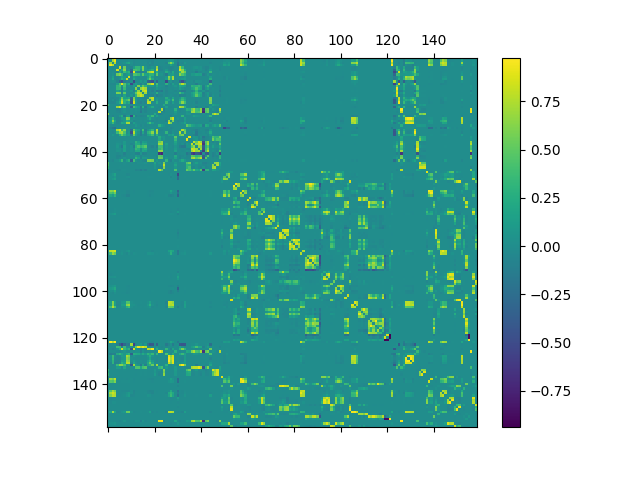

In [75]:
si.plot_template_similarity(analyzer)

### Compute correlograms

In [76]:
analyzer.compute("correlograms")

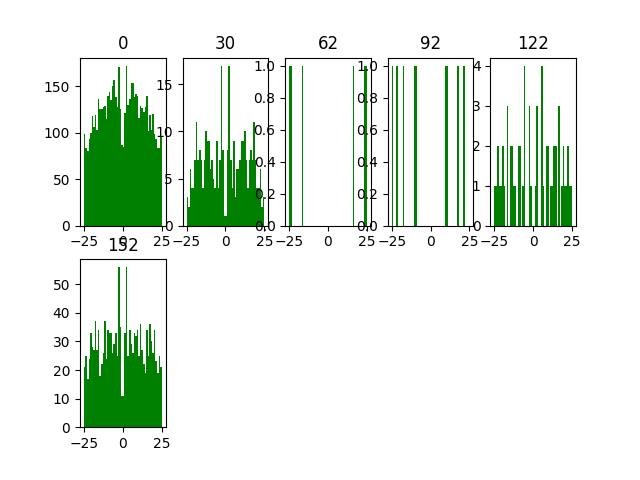

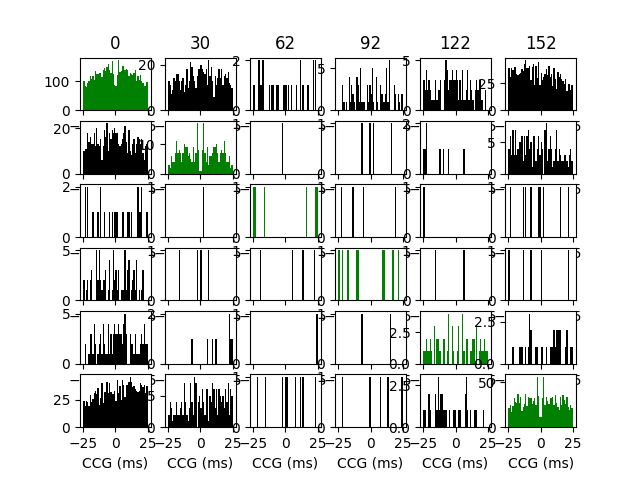

In [77]:
si.plot_autocorrelograms(analyzer, unit_ids=sorting.unit_ids[::30])
si.plot_crosscorrelograms(analyzer, unit_ids=sorting.unit_ids[::30])

### Principal components

PCA scores can be easily computed with the `"principal_components"` extension. Similarly to the `"waveforms"`, the function compute the components only on some random spikes.

Can be done with `si.compute_principal_components(analyzer, ...)` or `analyzer.compute("principal_components", ...)`




In [78]:
analyzer.compute("principal_components", n_components=3, mode="by_channel_global")
analyzer

Fitting PCA:   0%|          | 0/159 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/159 [00:00<?, ?it/s]

SortingAnalyzer: 49 channels - 159 units - 1 segments - memory - sparse - has recording
Loaded 10 extensions: random_spikes, waveforms, templates, noise_levels, spike_amplitudes, unit_locations, spike_locations, template_similarity, correlograms, principal_components

### Compute template metrics

Template metrics, or extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `postprocessing` allows one to compute several of these metrics:

In [79]:
print(si.get_template_metric_names())

['peak_to_valley', 'peak_trough_ratio', 'half_width', 'repolarization_slope', 'recovery_slope', 'num_positive_peaks', 'num_negative_peaks', 'velocity_above', 'velocity_below', 'exp_decay', 'spread']


In [80]:
# analyzer.compute("template_metrics")
template_metrics = si.compute_template_metrics(analyzer)
display(template_metrics)

,peak_to_valley,peak_trough_ratio,half_width,repolarization_slope,recovery_slope,num_positive_peaks,num_negative_peaks
0,0.00085,-0.271363,0.000317,85137.934657,-12727.292086,2,1
1,0.000943,-0.235764,0.000257,307891.437514,-47309.981698,2,1
2,0.00073,-0.302573,0.000287,289201.497299,-42246.385143,1,1
3,0.000813,-0.305366,0.000293,151673.86514,-22635.330766,2,1
4,0.00076,-0.28953,0.000287,255707.778623,-36393.180101,1,1
...,...,...,...,...,...,...,...
156,0.000917,-0.227531,0.000197,115464.118578,-17208.598229,1,1
157,0.00108,-0.40989,0.000703,40919.816014,-8277.177642,2,1
158,0.000727,-0.304598,0.00029,183948.874136,-27231.093226,1,1
159,0.000833,-0.255242,0.000313,164285.765753,-17649.096558,2,1


In [81]:
w = si.plot_template_metrics(analyzer, include_metrics=["peak_to_valley", "half_width"], backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

For more information about these template metrics, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

# 6. Quality metrics and curation <a class="anchor" id="curation"></a>

The `qualitymetrics` module also provides several functions to compute qualitity metrics to validate the spike sorting results.

Let's see what metrics are available:

In [82]:
print(si.get_quality_metric_list())
print(si.get_quality_pca_metric_list())

['num_spikes', 'firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'rp_violation', 'sliding_rp_violation', 'amplitude_cutoff', 'amplitude_median', 'amplitude_cv', 'synchrony', 'firing_range', 'drift', 'sd_ratio']
['isolation_distance', 'l_ratio', 'd_prime', 'nearest_neighbor', 'nn_isolation', 'nn_noise_overlap', 'silhouette']


In [83]:
metric_names = si.get_quality_metric_list()
qm = si.compute_quality_metrics(analyzer, metric_names=metric_names)

noise_level:   0%|          | 0/20 [00:00<?, ?it/s]

In [84]:
display(qm)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,...,amplitude_cv_median,amplitude_cv_range,sync_spike_2,sync_spike_4,sync_spike_8,firing_range,drift_ptp,drift_std,drift_mad,sd_ratio
0,3598,11.993333,1.0,6.047838,0.942405,122,1.0,87,<NA>,0.000157,...,0.38383,0.280381,0.031962,0,0,5.62,0.258883,0.101139,0.093107,2.206612
1,1575,5.25,1.0,22.642986,0.120937,3,0.062417,1,0.215,0.002504,...,0.151045,0.417312,0.045079,0,0,3.21,0.999655,0.367169,0.370746,4.774676
2,98,0.326667,1.0,15.249896,0.0,0,0.0,0,<NA>,<NA>,...,<NA>,<NA>,0.265306,0,0,0.61,<NA>,<NA>,<NA>,2.865849
3,745,2.483333,1.0,8.630683,1.261204,7,1.0,5,<NA>,0.006556,...,0.303898,0.254613,0.036242,0,0,3.21,1.498647,0.63232,0.68667,1.804273
4,997,3.323333,1.0,13.248806,0.503014,5,0.692469,3,<NA>,0.000602,...,0.205309,0.064368,0.045135,0,0,2.41,0.430673,0.141879,0.049792,2.419502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,577,1.923333,1.0,8.379984,4.205101,14,1.0,9,<NA>,0.00729,...,0.447972,0.168047,0.07799,0,0,2.24,1.623331,0.357959,0.416724,3.290247
157,2141,7.136667,1.0,2.365223,0.130893,6,0.0,0,0.065,0.002321,...,0.425768,0.159922,0.012144,0,0,9.2,0.795459,0.260955,0.116437,0.961315
158,555,1.85,1.0,11.443817,5.519033,17,1.0,13,<NA>,0.00199,...,0.279369,0.068709,0.09009,0,0,2.21,0.418698,0.077211,0.177374,2.687851
159,337,1.123333,1.0,9.015975,0.0,0,0.0,0,<NA>,<NA>,...,<NA>,<NA>,0.017804,0,0,1.01,<NA>,<NA>,<NA>,2.147199


For more information about these waveform features, we refer to the [SpikeInterface documentation](https://spikeinterface.readthedocs.io/en/latest/module_qualitymetrics.html) and to this excellent [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

## Curation

Very often Kilosort is finding a unit severals times, which are also called "duplicate" units.

`spikeinterface` has a convenient function to find and remove these units:

In [85]:
sorting_clean = si.remove_redundant_units(analyzer)
print(analyzer.sorting)
print(sorting_clean)

NumpySorting: 159 units - 1 segments - 30.0kHz
UnitsSelectionSorting: 157 units - 1 segments - 30.0kHz


### Automatic curation based on quality metrics

A viable option to curate (or at least pre-curate) a spike sorting output is to filter units based on quality metrics. As we have already computed quality metrics a few lines above, we can simply filter the `qm` dataframe based on some thresholds.

Here, we'll only keep units with an ISI violation threshold < 0.5 and amplitude cutoff < 0.1:

In [86]:
isi_viol_thresh = 0.5
amp_cutoff_thresh = 0.1

A straightforward way to filter a pandas dataframe is via the `query`.
We first define our query (make sure the names match the column names of the dataframe):

In [87]:
our_query = f"amplitude_cutoff < {amp_cutoff_thresh} & isi_violations_ratio < {isi_viol_thresh}"
print(our_query)

amplitude_cutoff < 0.1 & isi_violations_ratio < 0.5


and then we can use the query to select units:

In [89]:
keep_units = qm.query(our_query)
keep_unit_ids = keep_units.index.values
keep_unit_ids

array([  1,   8,  10,  11,  13,  17,  21,  50,  65,  77,  96,  98, 106,
       111, 118, 137, 139, 144, 145, 148, 157, 160])

In [90]:
sorting_auto_KS25 = sorting.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(sorting.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto_KS25.get_unit_ids())}")

Number of units before curation: 159
Number of units after curation: 22


We can also save all the waveforms and post-processed data for curated units in a separate folder:

In [91]:
analyzer_curated = analyzer.select_units(keep_unit_ids)
analyzer_curated

SortingAnalyzer: 49 channels - 22 units - 1 segments - memory - sparse - has recording
Loaded 12 extensions: random_spikes, waveforms, templates, noise_levels, spike_amplitudes, unit_locations, spike_locations, template_similarity, correlograms, principal_components, template_metrics, quality_metrics

## Save the SortingAnalyzer

There are two possible formats one can save the `SortingAnalyzer` to: `binary_folder` and `zarr`.

Note that the `save_as()` function returns a new `SortingAnalyzer` object, which is now bound to a location on disk.
This means that additional extensions can be directly saved to disk.

In [ ]:
analyzer_saved = analyzer.save_as(folder=base_folder / "analyzer_KS25", format="binary_folder")

analyzer_curated_saved = analyzer_curated.save_as(folder=base_folder / "analyzer_KS25_curated.zarr", format="zarr")

print(analyzer_saved)
print(analyzer_curated_saved)

We can easily reload a `SortingAnalyzer` later on as follows:

In [ ]:
analyzer_curated = si.load_sorting_analyzer(base_folder / "analyzer_KS25_curated.zarr")
analyzer_curated

# 7. Viewers <a class="anchor" id="viewers"></a>


### SpikeInterface GUI

A QT-based GUI built on top of SpikeInterface objects.

Developed by Samuel Garcia, CRNL, Lyon.

This can be run directly in a termnal with

```bash
sigui /path/to/analyzer
```

or from python

In [92]:
%gui qt
si.plot_sorting_summary(analyzer_curated, backend="spikeinterface_gui")

### Sorting Summary - SortingView

The `sortingview` backend requires an additional step to configure the transfer of the data to be plotted to the cloud. 

See documentation [here](https://spikeinterface.readthedocs.io/en/latest/module_widgets.html).

Developed by Jeremy Magland and Jeff Soules, Flatiron Institute, NYC

In [ ]:
w = si.plot_sorting_summary(analyzer_curated, backend="sortingview", curation=True)

https://figurl.org/f?v=npm://@fi-sci/figurl-sortingview@12/dist&d=sha1://25a4806d783177eb246420c416c1139de51503d3

# 9. Spike sorting comparison <a class="anchor" id="comparison"></a>

Do the outputs of different sorters agree with each other?

To answer this question we can use the `comparison` module.

### Compare two sorters

In [ ]:
comp_KS2_KS25 = si.compare_two_sorters(sorting_KS2, sorting_KS25, 'KS2', 'KS25')

In [ ]:
w = si.plot_agreement_matrix(comp_KS2_KS25)

### Compare multiple sorters

In [ ]:
si.compare_multiple_sorters?

In [ ]:
multi_comp = si.compare_multiple_sorters(
    sorting_list=[sorting_KS2, sorting_KS25, sorting_KS4],
    name_list=['KS2', 'KS25', 'KS4'],
    spiketrain_mode='union',
    verbose=True
)

In [ ]:
w = si.plot_multicomparison_agreement(multi_comp)
w = si.plot_multicomparison_agreement_by_sorter(multi_comp)

# 10. Exporters <a class="anchor" id="exporters"></a>

## Export to Phy for manual curation

To perform manual curation we can also export the data to [Phy](https://github.com/cortex-lab/phy):

```python
si.export_to_phy(analyzer, output_folder=base_folder / 'phy_KS25', 
                   compute_amplitudes=False, compute_pc_features=False, copy_binary=False,
                   )
```

After curating the results we can reload it using the `read_phy` and exclude the units that we labeled as `noise`:

```python
sorting_phy_curated = si.read_phy(base_folder / 'phy_KS25/', exclude_cluster_groups=['noise'])
```

## Export a "spike sorting" report to a folder

This export function creates a bunch figures figures that summarize the sorting results:

In [ ]:
si.export_report(analyzer_curated, output_folder=base_folder / 'report_KS25_curated')

### Et voilà!